# Teaching statistical inference with resampling

Copyright 2018 Allen Downey

License: http://creativecommons.org/licenses/by/4.0/

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import matplotlib.pyplot as plt

## The Euro problem

From MacKay, *Information Theory, Inference, and Learning Algorithms*:

"A statistical statement appeared in *The Guardian* on Friday January 4, 2002:

When spun on edge 250 times, a Belgian one-euro coin came
up heads 140 times and tails 110. ‘It looks very suspicious
to me’, said Barry Blight, a statistics lecturer at the London
School of Economics. ‘If the coin were unbiased the chance of
getting a result as extreme as that would be less than 7%’.

But do these data give evidence that the coin is biased rather than fair?"

Using "these data" as a starting place, let's simulate spinning a coin 250 times.

In [2]:
heads, tails = 140, 110

The total number of spins:

In [3]:
sample_size = heads + tails

250

The observed proportion of heads:

In [4]:
observed_proportion = heads / sample_size

0.56

We'll run two simulation, based on different assumptions, and compare them:

1. First we'll assume that the observed proportion is correct, and that the actual long-term probability that the coin lands heads is 140/250 = 56%.

2. Next we'll assume that the coin is actually fair, so the probability that the coin lands heads is 50%.

Here's a simple way to generate an array of outcomes, where the boolean value `True` represents heads.

In [5]:
flips = np.random.random(10) < observed_proportion

array([False,  True,  True,  True, False,  True,  True,  True, False,
        True])

The sum of this array is the number of heads.

In [6]:
np.sum(flips)

7

We can wrap that in a function that simulates `n` spins with probability `p`. 

In [7]:
def flip(n, p):
    return np.sum(np.random.random(n) < p)

Here's an example with the actual sample size (250) and observed proportion (56%).

In [216]:
flip(sample_size, observed_proportion)

129

Each time we run this simulated experiment, we get different results.

Here's a function that runs the experiment (250 spins) many times, and collects the results (number of heads) in an array.

In [9]:
def run_experiments(n, p, iters):
    t = [flip(n, p) for i in range(iters)]
    return np.array(t)

`outcomes` is an array of 1000 integers, each representing the number of heads in a simulated experiment.

In [224]:
outcomes = run_experiments(sample_size, observed_proportion, 1000);

The following function draws a histogram of the values in `sample`:

In [232]:
def hist(sample, low=None, high=None):
    # draw the histogram
    options = dict(alpha=0.5, color='C0')
    xs, ys, patches = plt.hist(sample,
                               density=True,
                               histtype='step', 
                               linewidth=3,
                               **options)
    
    # fill in the histogram, if desired
    if low is not None:
        x1 = low
        if high is not None:
            x2 = high
        else:
            x2 = np.max(sample)
            
        fill = plt.axvspan(x1, x2, 
                           clip_path=patches[0],
                           **options)
    plt.ylabel('PMF')

Here's what it looks like.

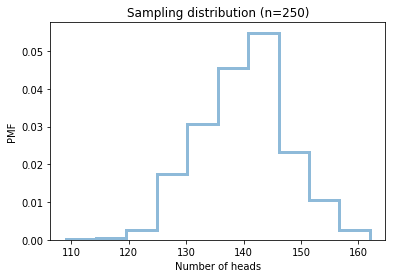

In [233]:
hist(outcomes)

plt.title('Sampling distribution (n=250)')
plt.xlabel('Number of heads');

This is the "sampling distribution" of the outcomes.  It shows how much variability we should expect between experiments with this sample size (n = 250).

The center of this distribution is near the observed outcome, 140 heads.  That's what we expect because these simulated experiments are based on the assumption that the actual probability of heads is 140/250.

In [234]:
np.mean(outcomes)

140.08

If we run the experiment again, we should expect outcomes between 120 and 160 most of the time.

We can quantify the variability of the distribution by computing the standard deviation of the sampling distribution, which is called "standard error".

[Sticklers will notice that I am eliding a detail here.]

In [235]:
std_err = np.std(outcomes)

7.589835307831126

We can also summarize the sampling distribution with a "confidence interval", which is a range that contains a specified fraction, like 90%, of the values in `outcomes`.

The central 90% confidence interval is between the 5th and 95th percentiles of `outcomes`.

In [236]:
ci_90 = np.percentile(outcomes, [5, 95])

array([128., 154.])

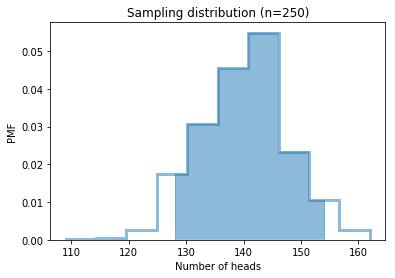

In [237]:
low, high = ci_90
hist(outcomes, low, high)

plt.title('Sampling distribution (n=250)')
plt.xlabel('Number of heads');

## P-values

In the previous section, we made the credulous assumption that the observed proportion, 56%, is the actual probability of heads.

In this section we consider the alternative, the skeptical assumption that the coin is actually fair.  In that case, the probability of heads is 50%.

Then we can consider the question: if the coin is actually fair, is it likely we would see an outcome as extreme as 140 heads out of 250 spins?

Let's simulate the experiment 1000 times:

In [212]:
outcomes2 = run_experiments(sample_size, 0.5, 1000);

In [213]:
np.mean(outcomes2 >= heads)

0.038

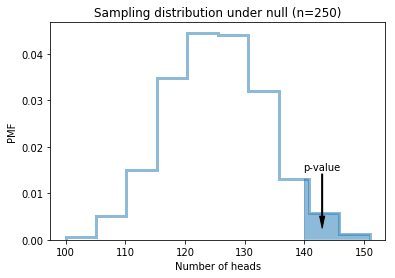

In [215]:
hist(outcomes2, heads)

x = heads+3
plt.annotate('p-value', xy=(x, 0.0025), xytext=(x, 0.015), ha='center',
             arrowprops=dict(width=1, headwidth=5, facecolor='black'))

plt.title('Sampling distribution under null (n=250)')
plt.xlabel('Number of heads');

## BFRSS

In [17]:
import thinkstats2 as ts

In [18]:
import pandas as pd

In [19]:
df = pd.read_sas('LLCP2016.XPT')
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_MAM5021,_RFPAP33,_RFPSA21,_RFBLDS3,_COL10YR,_HFOB3YR,_FS5YR,_FOBTFS,_CRCREC,_AIDTST3
0,1.0,1.0,b'01072016',b'01',b'07',b'2016',1100.0,b'2016000001',2.016000e+09,1.0,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1.0,1.0,b'01112016',b'01',b'11',b'2016',1100.0,b'2016000002',2.016000e+09,1.0,...,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,2.0
2,1.0,1.0,b'01062016',b'01',b'06',b'2016',1100.0,b'2016000003',2.016000e+09,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,1.0,1.0,b'01082016',b'01',b'08',b'2016',1100.0,b'2016000004',2.016000e+09,1.0,...,NaN,NaN,1.0,2.0,1.0,2.0,NaN,2.0,1.0,9.0
4,1.0,1.0,b'01052016',b'01',b'05',b'2016',1100.0,b'2016000005',2.016000e+09,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [20]:
columns = ['SEX', 'HTM4', 'WTKG3', '_LLCPWT']
selected = df[columns]
selected.to_hdf('LLCP2016.HDF', 'brfss')

In [21]:
df = pd.read_hdf('LLCP2016.HDF')
df.head()

,SEX,HTM4,WTKG3,_LLCPWT
0,1.0,173.0,6123.0,767.844566
1,2.0,160.0,6940.0,329.659884
2,2.0,165.0,5443.0,290.749306
3,1.0,185.0,9979.0,211.039206
4,1.0,168.0,5670.0,1582.539834


In [22]:
df['SEX'].describe()

count    486303.000000
mean          1.567874
std           0.502985
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           9.000000
Name: SEX, dtype: float64

In [23]:
df['HTM4'].describe()

count    469331.000000
mean        169.623291
std          10.580891
min          91.000000
25%         163.000000
50%         168.000000
75%         178.000000
max         234.000000
Name: HTM4, dtype: float64

In [24]:
df['WTKG3'].describe()

count    452773.000000
mean       8107.886435
std        2045.898917
min        2268.000000
25%        6668.000000
50%        7893.000000
75%        9072.000000
max       29257.000000
Name: WTKG3, dtype: float64

In [25]:
df['_LLCPWT'].describe()

count    486303.000000
mean        522.618894
std         960.497435
min           0.191186
25%          86.294955
50%         216.519496
75%         547.498391
max       37604.076933
Name: _LLCPWT, dtype: float64

In [26]:
males = df[df.SEX==1]
print('Mean male height in cm =', males.HTM4.mean())
print('Std male height in cm =', males.HTM4.std())

Mean male height in cm = 178.06121490985726
Std male height in cm = 7.7928971536184335


In [27]:
def sample_stat(data):
    return np.nanmean(data)

In [28]:
data = males.HTM4
xbar = sample_stat(data)

178.06121490985726

In [29]:
def resample(df):
    size = len(df)
    data = df.HTM4
    p = df._LLCPWT
    p /= np.sum(p)
    return np.random.choice(data, size=size, replace=True, p=p)

In [30]:
sample_stat(resample(males))

177.515778363075

In [31]:
sampling_dist_mean = [sample_stat(resample(df)) for i in range(1000)];

In [32]:
xbar_weighted = np.mean(sampling_dist_mean)

170.13627856543997

In [131]:
def show_sampling_dist(sampling_dist):
    hist(sampling_dist)
    print('Mean = ', np.mean(sampling_dist))
    print('Std error = ', np.std(sampling_dist))
    print('90% CI = ', np.percentile(sampling_dist, [5, 95]))

In [132]:
show_sampling_dist(sampling_dist_mean)
plt.title('Sampling distribution of the mean')
plt.xlabel('Mean adult male height, U.S.')
plt.ylabel('Count');

NameError: name 'sampling_dist_mean' is not defined

In [35]:
def analytic_stderr(df):
    males = df[df.SEX==1]
    size = len(males)
    a = males.HTM4
    return np.std(a) / np.sqrt(size)

In [36]:
analytic_stderr(df)

0.01698097071589304

In [37]:
def sample_stat(data):
    return np.nanstd(data) / np.nanmean(data) * 100

In [38]:
sampling_dist_cv = [sample_stat(resample(df)) for i in range(1000)];

Mean =  6.349645493705175
Std error =  0.006842939432531431
90% CI =  [6.33858613 6.3609145 ]


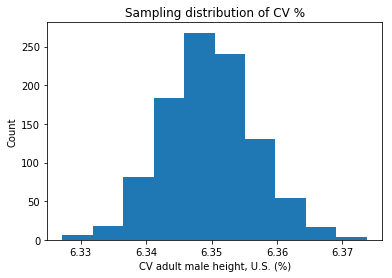

In [39]:
show_sampling_dist(sampling_dist_cv)
plt.title('Sampling distribution of CV %')
plt.xlabel('CV adult male height, U.S. (%)')
plt.ylabel('Count');

In [80]:
import nsfg

df = nsfg.ReadFemPreg()
df.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875


In [81]:
live = df[df.outcome == 1]
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

len(firsts), len(others)

(4413, 4735)

In [82]:
group1 = firsts.prglngth
group2 = others.prglngth

np.mean(group1), np.mean(group2)

(38.60095173351461, 38.52291446673706)

In [83]:
def test_stat(data):
    group1, group2 = data
    return group1.mean() - group2.mean()

In [84]:
data = group1, group2
actual = test_stat(data)

0.07803726677754952

In [85]:
def run_model(data):
    group1, group2 = data
    pool = np.hstack((group1, group2))
    np.random.shuffle(pool)
    n = len(group1)
    return np.split(pool, [n])

In [86]:
run_model(data)

[array([40, 40, 39, ..., 26, 39, 40]), array([39, 36, 36, ..., 39, 39, 41])]

In [87]:
test_stat(run_model(data))

-0.07606708699529463

In [88]:
test_stats = np.array([test_stat(run_model(data)) 
                       for i in range(1000)])
np.mean(test_stats)

0.002611065942014953

In [133]:
def plot_test_stats(test_stats, actual):
    hist(test_stats, actual)
    plt.xlabel('Difference in means')
    plt.ylabel('Count')
    plt.title('Distribution of test stat under null')

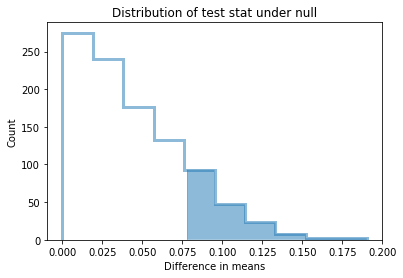

In [134]:
plot_test_stats(test_stats, actual)

In [135]:
def p_value(test_stats, actual):
    return np.mean(test_stats >= actual)

In [136]:
p_value(test_stats, actual)

0.163

In [137]:
def test_stat(data):
    group1, group2 = data
    return abs(group1.mean() - group2.mean())

0.187

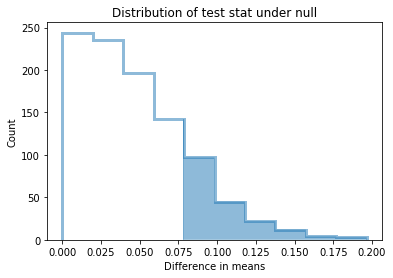

In [138]:
test_stats = np.array([test_stat(run_model(data)) 
                       for i in range(1000)])
plot_test_stats(test_stats, actual)
p_value(test_stats, actual)

In [139]:
class HypothesisTest(object):
    """Represents a hypothesis test."""

    def __init__(self, data):
        """Initializes.

        data: data in whatever form is relevant
        """
        self.data = data
        self.actual = self.test_stat(data)
        self.test_stats = np.array([self.test_stat(self.run_model())
                                    for i in range(1000)])

    def p_value(self):
        """Computes the p-value.

        returns: float p-value
        """
        return np.mean(self.test_stats >= self.actual)

    def plot_test_stats(self):
        """Draws a Cdf with vertical lines at the observed test stat.
        """
        hist(self.test_stats, self.actual)
        plt.ylabel('Count')
        plt.title('Distribution of test stat under null')
        
    def test_stat(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        raise UnimplementedMethodException()

    def run_model(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        raise UnimplementedMethodException()

In [140]:
class PermutationTest(HypothesisTest):
    """Tests a difference in means by permutation."""

    def run_model(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        n = len(self.data[0])
        pool = np.hstack(self.data)
        np.random.shuffle(pool)
        data = np.split(pool, [n])
        return data

In [141]:
class DiffMeansPermute(PermutationTest):
    """Tests a difference in means by permutation."""

    def test_stat(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        return abs(group1.mean() - group2.mean())

Diff means permute pregnancy length
actual = 0.07803726677754952
p-value = 0.148


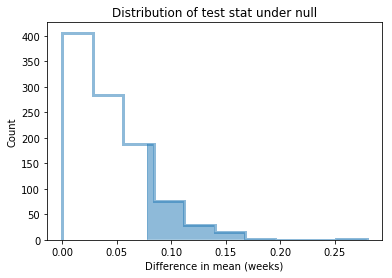

In [142]:
data = (firsts.prglngth, others.prglngth)
ht = DiffMeansPermute(data)
p_value = ht.p_value()

print('Diff means permute pregnancy length')
print('actual =', ht.actual)
print('p-value =', p_value)
ht.plot_test_stats()
plt.xlabel('Difference in mean (weeks)');

In [143]:
class DiffStdPermute(PermutationTest):
    """Tests a difference in means by permutation."""

    def test_stat(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        return abs(group1.std() - group2.std())

Diff std permute pregnancy length
actual = 0.1760490642294399
p-value = 0.165


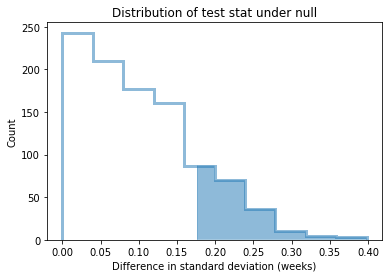

In [144]:
data = (firsts.prglngth, others.prglngth)
ht = DiffStdPermute(data)
p_value = ht.p_value()

print('Diff std permute pregnancy length')
print('actual =', ht.actual)
print('p-value =', p_value)
ht.plot_test_stats()
plt.xlabel('Difference in standard deviation (weeks)');